# Corr with SC for all cell types

## All control cell types

In [1]:
# let's solve it all at once
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "other_celltypes")

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

### RNA

In [3]:
celltype_names = []
positive_nbr = []
negative_nbr = []
for file in Path("./").glob("*rna_matrix.mtx"):
    celltype = str(file).split("_rna_matrix", 1)[0]
    print(celltype)
    celltype_names.append(celltype)
    
    # rna_counts = sc.read_mtx("{}_rna_matrix.mtx".format(celltype))
    # rna_counts = rna_counts.T.copy()
    # cell_meta = pd.read_csv("{}_meta_data.tsv".format(celltype), header=0, index_col=0, sep="\t")
    # gene_names = pd.read_csv("{}_gene_names.tsv".format(celltype), header=None, index_col=0, sep="\t")
    # gene_names.index.name = None
    # rna_counts.obs = cell_meta
    # rna_counts.var = gene_names
    # rna_counts.write("{}_rna_matrix.h5ad".format(celltype))

    rna_counts = sc.read_h5ad("{}_rna_matrix.h5ad".format(celltype))
    if celltype in ["L4_IT","SST_CHODL", "L5_ET"]:
        rna_counts = rna_counts.raw.to_adata()
    rna_counts.obs["Donor_Region"] = \
        rna_counts.obs["PatientID"].astype("str") + "_" + rna_counts.obs["Region"].astype("str")
    rna_region_counts = dc.get_pseudobulk(
        adata=rna_counts,
        sample_col="Donor_Region",
        groups_col=None,
        min_cells=0,
        min_counts=0,
        remove_empty=True,
        mode="sum"
    )
    kept_genes = dc.filter_by_expr(
        rna_region_counts,
        group="Region",
        min_count=10,
        min_total_count=15
    )
    if len(kept_genes) <= 5:
        print("{} <=5 genes left after filtering...".format(celltype))
        continue

    sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
    sc.pp.log1p(rna_region_counts, base=2)
    rna_region_counts = rna_region_counts[:, kept_genes].copy()
    region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
    rna_region_counts.obs["Region"] = pd.Categorical(
        rna_region_counts.obs["Region"], categories=region_align
    )
    sorted_index = rna_region_counts.obs.sort_values(by="Region").index
    b = rna_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
    data_matrix = rna_region_counts[sorted_index, :].X
    corrs = np.zeros(data_matrix.shape[1])
    pvalues = np.zeros(data_matrix.shape[1])
    
    for i in range(0, data_matrix.shape[1]):
        a = data_matrix[:, i]
        corr, pvalue = stats.spearmanr(a, b)
        corrs[i] = corr
        pvalues[i] = pvalue
    padjusted = stats.false_discovery_control(pvalues, method="bh")
    spearman_result = pd.DataFrame({
        "gene": rna_region_counts.var.index.to_list(),
        "corr": corrs,
        "p_value": pvalues,
        "p_adjusted": padjusted,
    })

    spearman_result.to_csv(
        "corr_genes_7e-1_1e-2_expr_filtered/{}_RC_table.tsv".format(celltype), sep="\t", header=True, index=False)

    pos_genes = spearman_result[
        (spearman_result["p_adjusted"] < 0.01) &
        (spearman_result["corr"] > 0.7)
    ]["gene"].to_list()
    positive_nbr.append(len(pos_genes))
    with open("corr_genes_7e-1_1e-2_expr_filtered/{}_positive.tsv".format(celltype), "w") as fout:
        for gene in pos_genes:
            fout.write("{}\n".format(gene))

    neg_genes = spearman_result[
        (spearman_result["p_adjusted"] < 0.01) &
        (spearman_result["corr"] < -0.7)
    ]["gene"].to_list()
    negative_nbr.append(len(neg_genes))
    with open("corr_genes_7e-1_1e-2_expr_filtered/{}_negative.tsv".format(celltype), "w") as fout:
        for gene in neg_genes:
            fout.write("{}\n".format(gene))
            
    with open("corr_genes_7e-1_1e-2_expr_filtered/{}_full_list.tsv".format(celltype), "w") as fout:
        for gene in spearman_result["gene"].to_list():
            fout.write("{}\n".format(gene))

Micro
L5_IT
L6_IT
L6_IT_Car3
LAMP5_LHX6
OPC
L6B
L6_CT
VLMC
Oligo
PAX6
Chandelier
L2_3_IT
SST_CHODL
Astro
SST
LAMP5
PVALB
Endo
SNCG
L5_ET
VIP
L5_6_NP
L4_IT


In [4]:
plot_table_wide = pd.DataFrame({
    "celltype": celltype_names,
    "positive": positive_nbr,
    "negative": negative_nbr
})

In [5]:
plot_table_wide.to_csv(
    "summary_tables/rostral_caudal_corr_genes_all_celltypes.tsv",
    header=True, index=False, sep="\t"
)

In [3]:
plot_table_wide = pd.read_csv(
    "summary_tables/rostral_caudal_corr_genes_all_celltypes.tsv",
    header=0, sep="\t"
)

In [4]:
plot_table_wide["total"] = plot_table_wide["positive"] + plot_table_wide["negative"]
sorted_index = plot_table_wide.sort_values("total", ascending=False)["celltype"]
plot_table_wide["celltype"] = pd.Categorical(plot_table_wide["celltype"], categories=sorted_index)
plot_table_long = pd.melt(
    plot_table_wide, 
    id_vars=["celltype"], 
    value_vars=["positive", "negative"],
    var_name="direction",
    value_name="corr_score"
)

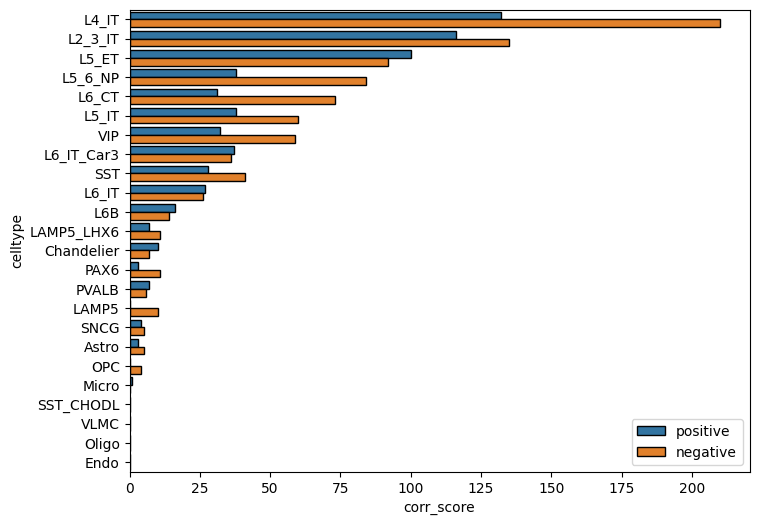

In [5]:
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized/")
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8),
fig.set_figheight(6)
sns.barplot(
    plot_table_long, 
    y="celltype", 
    x="corr_score", 
    hue="direction", 
    ax=ax, 
    linewidth=1,
    edgecolor="black"
)
plt.legend(loc="lower right")
fig.savefig(plot_dir / "RC_all_corr_7e-1_bh_1e-2.pdf", dpi=300, format="pdf")

### ATAC

In [9]:
celltype_names = []
positive_nbr = []
negative_nbr = []
for file in Path("./").glob("*atac_matrix.mtx"):
    celltype = str(file).split("_atac_matrix", 1)[0]
    print(celltype)
    celltype_names.append(celltype)
    
    # atac_counts = sc.read_mtx("{}_atac_matrix.mtx".format(celltype))
    # atac_counts = atac_counts.T.copy()
    # cell_meta = pd.read_csv("{}_meta_data.tsv".format(celltype), header=0, index_col=0, sep="\t")
    # region_names = pd.read_csv("{}_region_names.tsv".format(celltype), header=None, index_col=0, sep="\t")
    # region_names.index.name = None
    # atac_counts.obs = cell_meta
    # atac_counts.var = region_names
    # atac_counts.write("{}_atac_matrix.h5ad".format(celltype))

    atac_counts = sc.read_h5ad("{}_atac_matrix.h5ad".format(celltype))
    atac_counts.obs["Donor_Region"] = \
        atac_counts.obs["PatientID"].astype("str") + "_" + atac_counts.obs["Region"].astype("str")
    atac_region_counts = dc.get_pseudobulk(
        adata=atac_counts,
        sample_col="Donor_Region",
        groups_col=None,
        min_cells=0,
        min_counts=0,
        remove_empty=True,
        mode="sum"
    )
    kept_regions = dc.filter_by_expr(
        atac_region_counts,
        group="Region",
        min_count=5,
        min_total_count=15
    )
    if len(kept_regions) <= 5:
        print("{} <=5 regions left after filtering...".format(celltype))
        continue

    sc.pp.normalize_total(atac_region_counts, target_sum=1e6)
    sc.pp.log1p(atac_region_counts, base=2)
    atac_region_counts = atac_region_counts[:, kept_regions].copy()
    region_align = ["A24", "A9", "FI", "M1C", "S1C", "MTG", "A1C", "AnG", "V1C"]
    atac_region_counts.obs["Region"] = pd.Categorical(
        atac_region_counts.obs["Region"], categories=region_align
    )
    sorted_index = atac_region_counts.obs.sort_values(by="Region").index
    b = atac_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
    data_matrix = atac_region_counts[sorted_index, :].X
    corrs = np.zeros(data_matrix.shape[1])
    pvalues = np.zeros(data_matrix.shape[1])
    
    for i in range(0, data_matrix.shape[1]):
        a = data_matrix[:, i]
        corr, pvalue = stats.spearmanr(a, b)
        corrs[i] = corr
        pvalues[i] = pvalue
    padjusted = stats.false_discovery_control(pvalues, method="bh")
    spearman_result = pd.DataFrame({
        "region": atac_region_counts.var.index.to_list(),
        "corr": corrs,
        "p_value": pvalues,
        "p_adjusted": padjusted,
    })

    spearman_result.to_csv(
        "corr_regions_5e-1_5e-2_expr_filtered/{}_RC_table.tsv".format(celltype), sep="\t", header=True, index=False)

    pos_regions = spearman_result[
        (spearman_result["p_adjusted"] < 0.05) &
        (spearman_result["corr"] > 0.5)
    ]["region"].to_list()
    positive_nbr.append(len(pos_regions))
    with open("corr_regions_5e-1_5e-2_expr_filtered/{}_positive.tsv".format(celltype), "w") as fout:
        for region in pos_regions:
            fout.write("{}\n".format(region))

    neg_regions = spearman_result[
        (spearman_result["p_adjusted"] < 0.05) &
        (spearman_result["corr"] < -0.5)
    ]["region"].to_list()
    negative_nbr.append(len(neg_regions))
    with open("corr_regions_5e-1_5e-2_expr_filtered/{}_negative.tsv".format(celltype), "w") as fout:
        for region in neg_regions:
            fout.write("{}\n".format(region))
            
    with open("corr_regions_5e-1_5e-2_expr_filtered/{}_full_list.tsv".format(celltype), "w") as fout:
        for region in spearman_result["region"].to_list():
            fout.write("{}\n".format(region))

L4_IT
L2_3_IT
VLMC
Oligo
L5_6_NP
SST
VIP
OPC
Astro
L6_IT
SST_CHODL
SST_CHODL <=5 regions left after filtering...
LAMP5_LHX6
L5_IT
PVALB
Endo
Chandelier
L6_CT
L5_ET
SNCG
PAX6
Micro
L6_IT_Car3
LAMP5
L6B


In [12]:
plot_table_wide = pd.DataFrame({
    "celltype": [xx for xx in celltype_names if xx != "SST_CHODL"],
    "positive": positive_nbr,
    "negative": negative_nbr
})

In [13]:
plot_table_wide.to_csv(
    "summary_tables/rostral_caudal_corr_peaks_all_celltypes.tsv",
    header=True, index=False, sep="\t"
)

In [6]:
plot_table_wide = pd.read_csv(
    "summary_tables/rostral_caudal_corr_peaks_all_celltypes.tsv",
    header=0, sep="\t"
)

In [7]:
plot_table_wide["total"] = plot_table_wide["positive"] + plot_table_wide["negative"]
sorted_index = plot_table_wide.sort_values("total", ascending=False)["celltype"]
plot_table_wide["celltype"] = pd.Categorical(plot_table_wide["celltype"], categories=sorted_index)
plot_table_long = pd.melt(
    plot_table_wide, 
    id_vars=["celltype"], 
    value_vars=["positive", "negative"],
    var_name="direction",
    value_name="corr_score"
)

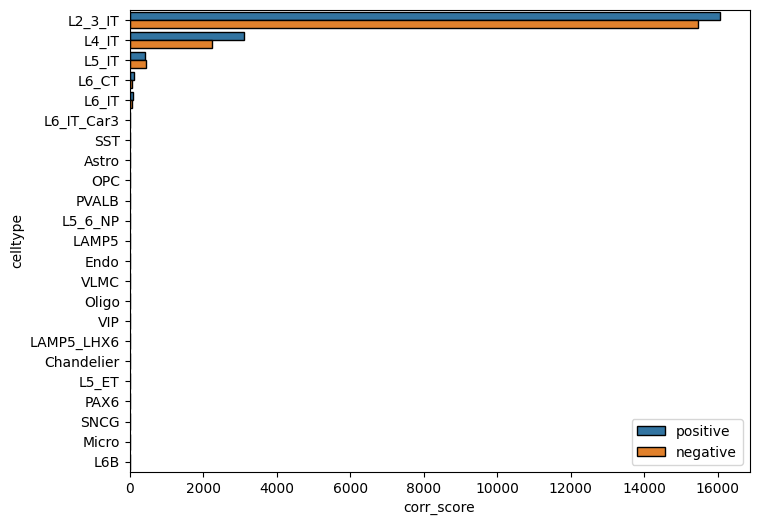

In [8]:
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized//")
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8),
fig.set_figheight(6)
sns.barplot(
    plot_table_long, 
    y="celltype", 
    x="corr_score", 
    hue="direction", 
    ax=ax, 
    linewidth=1,
    edgecolor="black"
)
plt.legend(loc="lower right")
fig.savefig(plot_dir / "RC_all_atac_corr_5e-1_bh_5e-2.pdf", dpi=300, format="pdf")

## Create upset plot to summarize correlated genes in different cell types

In [1]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "other_celltypes")
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/expr_filtered/")

In [2]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [3]:
import itertools

In [4]:
def generate_all_combinations_and_counts(lists):
    combination_codes = []
    number_instances = []

    N = len(lists)
    for k in range(2, N+1):
        for combinations in itertools.combinations(range(N), k):
            combination_codes.append(combinations)
            intersected = set(lists[combinations[0]])
            for idx in combinations[1:]:
                intersected &= set(lists[idx])
            number_instances.append(len(intersected))

    return (combination_codes, number_instances)

## RNA

In [5]:
celltype_order = []
lists = []
for file in Path("./corr_genes_7e-1_1e-2_expr_filtered/").glob("*_positive.tsv"):
    celltype = file.name.split("_positive.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [6]:
N = 20
K = len(celltype_sorted)

In [7]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [16]:
import matplotlib.gridspec as gridspec

In [17]:
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized/")

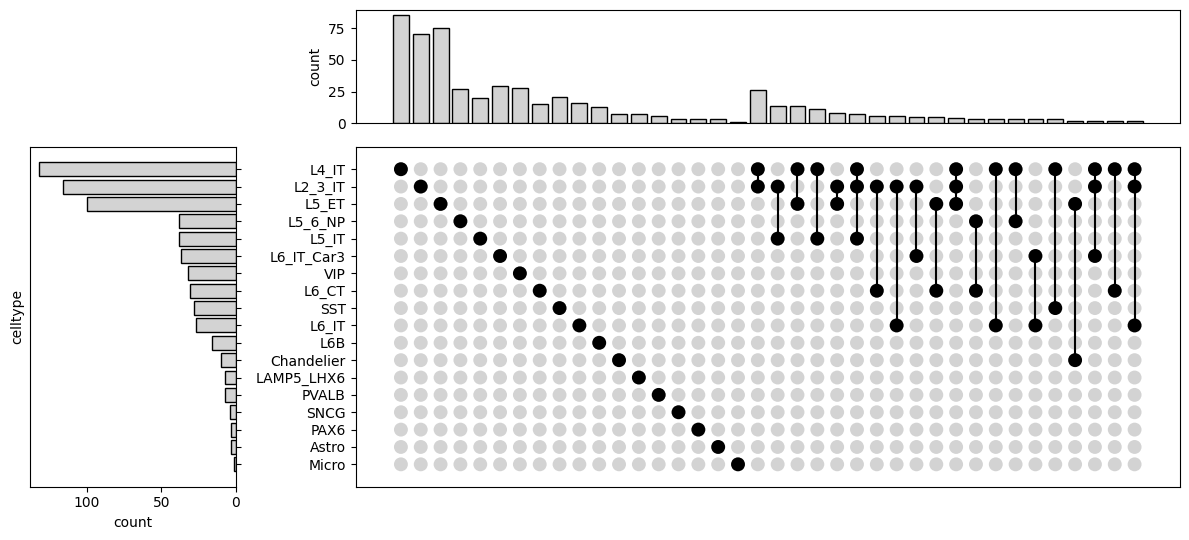

In [18]:
Nx = len(cc_final)
fig = plt.figure(figsize=(12, 5.5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 4])

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax2)

df_1 = pd.DataFrame({
    "celltype": celltype_sorted,
    "count": lists_len_sorted
})
sns.barplot(
    df_1,
    x="count",
    y="celltype",
    orient="h",
    ax=ax1,
    edgecolor="black",
    facecolor="lightgrey"
)
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False);

df_2 = pd.DataFrame({
    "count": number_instances_final
})
df_2.reset_index(inplace=True)
sns.barplot(
    df_2,
    x="index",
    y="count",
    ax=ax2,
    edgecolor="black",
    facecolor="lightgrey"
)
ax2.xaxis.set_ticks([]);
ax2.set_xticklabels([]);
ax2.set_xlabel("");

for i in range(Nx):
    ax3.scatter([i] * (K), np.arange(K), color="lightgrey", s=100, edgecolor="none")
points_by_x = {x: [] for x in range(Nx)}
for i, tuple_vals in enumerate(cc_final):
    ax3.scatter([i] * len(tuple_vals), tuple_vals, color="black", s=100, edgecolor="none")
    for x in tuple_vals:
        points_by_x[i].append(x)
for x, yvals in points_by_x.items():
    ax3.plot([x] * len(yvals), yvals, color="black", lw=1.5)
    
ax3.xaxis.set_ticks([]);
ax3.set_xticklabels([]);
ax3.set_xlabel("");
# ax3.yaxis.set_ticks(np.arange(0, K));
# ax3.invert_yaxis()
plt.tight_layout()
fig.savefig(plot_dir / "RC_all_positive_corr_7e-1_bh_1e-2_upset.pdf", dpi=300, format="pdf")

In [13]:
celltype_order = []
lists = []
for file in Path("./corr_genes_7e-1_1e-2_expr_filtered//").glob("*_negative.tsv"):
    celltype = file.name.split("_negative.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [14]:
N = 20
K = len(celltype_sorted)

In [15]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

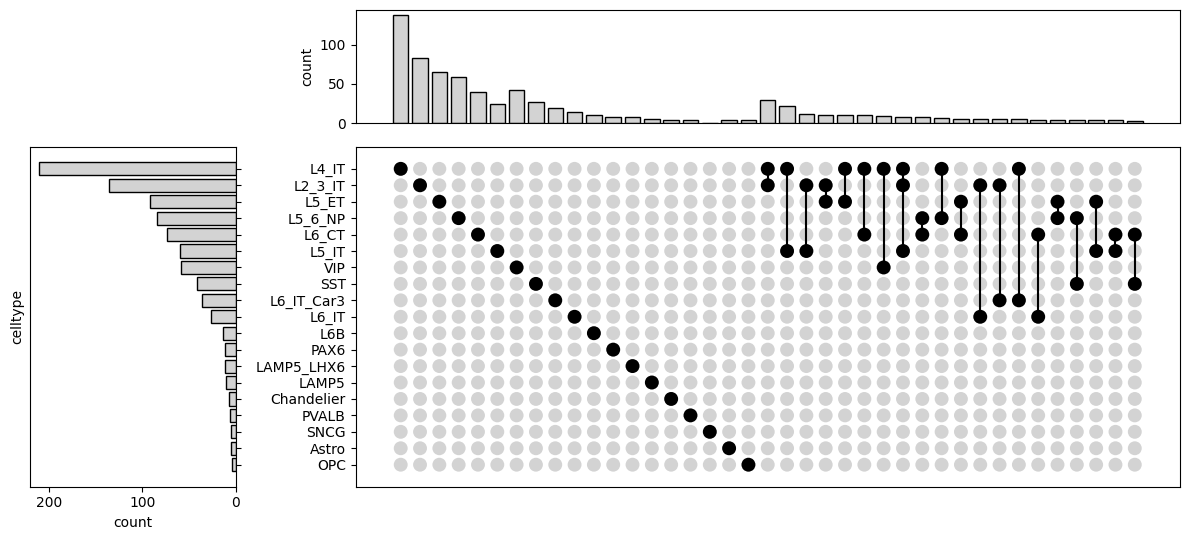

In [22]:
Nx = len(cc_final)
fig = plt.figure(figsize=(12, 5.5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 4])

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax2)

df_1 = pd.DataFrame({
    "celltype": celltype_sorted,
    "count": lists_len_sorted
})
sns.barplot(
    df_1,
    x="count",
    y="celltype",
    orient="h",
    ax=ax1,
    edgecolor="black",
    facecolor="lightgrey"
)
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False);

df_2 = pd.DataFrame({
    "count": number_instances_final
})
df_2.reset_index(inplace=True)
sns.barplot(
    df_2,
    x="index",
    y="count",
    ax=ax2,
    edgecolor="black",
    facecolor="lightgrey"
)
ax2.xaxis.set_ticks([]);
ax2.set_xticklabels([]);
ax2.set_xlabel("");

for i in range(Nx):
    ax3.scatter([i] * (K), np.arange(K), color="lightgrey", s=100, edgecolor="none")
points_by_x = {x: [] for x in range(Nx)}
for i, tuple_vals in enumerate(cc_final):
    ax3.scatter([i] * len(tuple_vals), tuple_vals, color="black", s=100, edgecolor="none")
    for x in tuple_vals:
        points_by_x[i].append(x)
for x, yvals in points_by_x.items():
    ax3.plot([x] * len(yvals), yvals, color="black", lw=1.5)
    
ax3.xaxis.set_ticks([]);
ax3.set_xticklabels([]);
ax3.set_xlabel("");
# ax3.yaxis.set_ticks(np.arange(0, K));
# ax3.invert_yaxis()
plt.tight_layout()
fig.savefig(plot_dir / "RC_all_negative_corr_7e-1_bh_1e-2_upset.pdf", dpi=300, format="pdf")

## ATAC

In [5]:
celltype_order = []
lists = []
for file in Path("./corr_regions_5e-1_5e-2_expr_filtered/").glob("*_positive.tsv"):
    celltype = file.name.split("_positive.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [6]:
N = 20
K = len(celltype_sorted)

In [7]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [18]:
print(lists_len_sorted.tolist())

[16058, 3108, 419, 111, 95, 26, 9, 8, 1, 1, 1, 1]


In [19]:
print(celltype_sorted)

['L2_3_IT', 'L4_IT', 'L5_IT', 'L6_CT', 'L6_IT', 'L6_IT_Car3', 'SST', 'Astro', 'L5_6_NP', 'OPC', 'Endo', 'PVALB']


In [20]:
print(number_instances_final)

[14648, 1842, 252, 80, 62, 16, 7, 2, 1, 0, 1, 1, 1248, 150, 49, 34, 29, 28, 10, 8, 8, 7, 6, 6, 6, 6, 5, 5, 5, 4, 4, 4]


In [21]:
celltype_order = []
lists = []
for file in Path("./corr_regions_5e-1_5e-2_expr_filtered/").glob("*_negative.tsv"):
    celltype = file.name.split("_negative.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [22]:
N = 20
K = len(celltype_sorted)

In [23]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [24]:
print(lists_len_sorted.tolist())

[15460, 2249, 454, 62, 61, 6, 5, 4, 3, 1, 1]


In [25]:
print(celltype_sorted)

['L2_3_IT', 'L4_IT', 'L5_IT', 'L6_IT', 'L6_CT', 'Astro', 'SST', 'L6_IT_Car3', 'OPC', 'LAMP5', 'PVALB']


In [26]:
print(number_instances_final)

[14502, 1431, 270, 37, 51, 3, 5, 1, 0, 1, 1, 791, 157, 46, 24, 20, 7, 3, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 0, 0, 0]


### Plot corr scores of corr genes in Jorstad paper

In [23]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "other_celltypes")
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized//")

In [24]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [25]:
jorstad_corr_genes = pd.read_csv("jorstad_rc_corr_genes.csv", sep=",", header=0)

In [26]:
jorstad_corr_genes["subclass"] = \
    jorstad_corr_genes["subclass"].str.replace("[/ ]", "_", regex=True)

In [27]:
all_dfs = []
for subclass in jorstad_corr_genes["subclass"].unique():
    if subclass in ["L6b", "Pvalb", "Sst", "Sst_Chodl", "Lamp5_Lhx6", "Sncg", "Vip"]:
        subclass = subclass.upper()
    subclass_df = jorstad_corr_genes[jorstad_corr_genes["subclass"] == subclass]
    filename = "corr_genes_7e-1_1e-2_expr_filtered/{}_RC_table.tsv".format(subclass)
    if not Path(filename).exists():
        print(subclass, filename)
        continue
    rc_df = pd.read_csv(filename, sep="\t", header=0, index_col=None)

    gene_list_p = subclass_df[subclass_df["cor_ap"] > 0]["gene"].to_list()
    df_p = rc_df[rc_df["gene"].isin(gene_list_p)]
    df_p["direction"] = "positive"
    df_p["subclass"] = subclass

    gene_list_n = subclass_df[subclass_df["cor_ap"] < 0]["gene"].to_list()
    df_n = rc_df[rc_df["gene"].isin(gene_list_n)]
    df_n["direction"] = "negative"
    df_n["subclass"] = subclass

    if df_p.shape[0] <= 0 or df_n.shape[0] <= 0:
        continue

    curr_df = pd.concat([df_p, df_n], axis=0)
    all_dfs.append(curr_df)

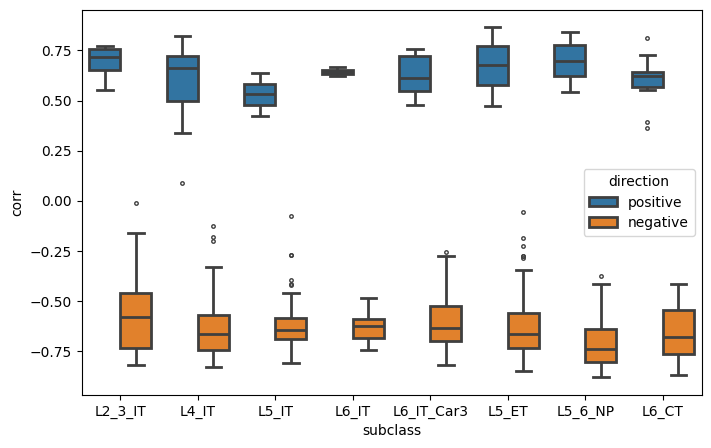

In [28]:
plot_df = pd.concat(all_dfs, axis=0)
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8)
fig.set_figheight(5)
sns.boxplot(
    plot_df,
    x="subclass",
    y="corr",
    hue="direction",
    linewidth=2,
    fliersize=2.5,
    ax=ax
)
fig.savefig(plot_dir / "RC_jorstad_genes_corr_scores.pdf", dpi=300, format="pdf")

# New perspective: Sensorimotor Transmodal axis

In [29]:
# let's solve it all at once
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "other_celltypes")

In [30]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [3]:
celltype_names = []
positive_nbr = []
negative_nbr = []
for file in Path("./").glob("*rna_matrix.mtx"):
    celltype = str(file).split("_rna_matrix", 1)[0]
    print(celltype)
    celltype_names.append(celltype)
    
    # rna_counts = sc.read_mtx("{}_rna_matrix.mtx".format(celltype))
    # rna_counts = rna_counts.T.copy()
    # cell_meta = pd.read_csv("{}_meta_data.tsv".format(celltype), header=0, index_col=0, sep="\t")
    # gene_names = pd.read_csv("{}_gene_names.tsv".format(celltype), header=None, index_col=0, sep="\t")
    # gene_names.index.name = None
    # rna_counts.obs = cell_meta
    # rna_counts.var = gene_names
    # rna_counts.write("{}_rna_matrix.h5ad".format(celltype))

    rna_counts = sc.read_h5ad("{}_rna_matrix.h5ad".format(celltype))
    if celltype in ["L4_IT","SST_CHODL", "L5_ET"]:
        rna_counts = rna_counts.raw.to_adata()
    rna_counts.obs["Donor_Region"] = \
        rna_counts.obs["PatientID"].astype("str") + "_" + rna_counts.obs["Region"].astype("str")
    rna_region_counts = dc.get_pseudobulk(
        adata=rna_counts,
        sample_col="Donor_Region",
        groups_col=None,
        min_cells=0,
        min_counts=0,
        remove_empty=True,
        mode="sum"
    )
    kept_genes = dc.filter_by_expr(
        rna_region_counts,
        group="Region",
        min_count=10,
        min_total_count=15
    )
    if len(kept_genes) <= 5:
        print("{} <=5 genes left after filtering...".format(celltype))
        continue

    sc.pp.normalize_total(rna_region_counts, target_sum=1e6)
    sc.pp.log1p(rna_region_counts, base=2)
    rna_region_counts = rna_region_counts[:, kept_genes].copy()
    region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]
    rna_region_counts.obs["Region"] = pd.Categorical(
        rna_region_counts.obs["Region"], categories=region_align
    )
    sorted_index = rna_region_counts.obs.sort_values(by="Region").index
    b = rna_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
    data_matrix = rna_region_counts[sorted_index, :].X
    corrs = np.zeros(data_matrix.shape[1])
    pvalues = np.zeros(data_matrix.shape[1])
    
    for i in range(0, data_matrix.shape[1]):
        a = data_matrix[:, i]
        corr, pvalue = stats.spearmanr(a, b)
        corrs[i] = corr
        pvalues[i] = pvalue
    padjusted = stats.false_discovery_control(pvalues, method="bh")
    spearman_result = pd.DataFrame({
        "gene": rna_region_counts.var.index.to_list(),
        "corr": corrs,
        "p_value": pvalues,
        "p_adjusted": padjusted,
    })

    spearman_result.to_csv(
        "corr_genes_ST_7e-1_1e-2_expr_filtered/{}_RC_table.tsv".format(celltype), sep="\t", header=True, index=False)

    pos_genes = spearman_result[
        (spearman_result["p_adjusted"] < 0.01) &
        (spearman_result["corr"] > 0.7)
    ]["gene"].to_list()
    positive_nbr.append(len(pos_genes))
    with open("corr_genes_ST_7e-1_1e-2_expr_filtered/{}_positive.tsv".format(celltype), "w") as fout:
        for gene in pos_genes:
            fout.write("{}\n".format(gene))

    neg_genes = spearman_result[
        (spearman_result["p_adjusted"] < 0.01) &
        (spearman_result["corr"] < -0.7)
    ]["gene"].to_list()
    negative_nbr.append(len(neg_genes))
    with open("corr_genes_ST_7e-1_1e-2_expr_filtered/{}_negative.tsv".format(celltype), "w") as fout:
        for gene in neg_genes:
            fout.write("{}\n".format(gene))
            
    with open("corr_genes_ST_7e-1_1e-2_expr_filtered/{}_full_list.tsv".format(celltype), "w") as fout:
        for gene in spearman_result["gene"].to_list():
            fout.write("{}\n".format(gene))

Micro
L5_IT
L6_IT
L6_IT_Car3
LAMP5_LHX6
OPC
L6B
L6_CT
VLMC
Oligo
PAX6
Chandelier
L2_3_IT
SST_CHODL
Astro
SST
LAMP5
PVALB
Endo
SNCG
L5_ET
VIP
L5_6_NP
L4_IT


In [4]:
plot_table_wide = pd.DataFrame({
    "celltype": celltype_names,
    "positive": positive_nbr,
    "negative": negative_nbr
})

In [5]:
plot_table_wide.to_csv(
    "summary_tables/ST_corr_genes_all_celltypes_7e-1_5e-2.tsv",
    header=True, index=False, sep="\t"
)

In [31]:
plot_table_wide = pd.read_csv(
    "summary_tables/ST_corr_genes_all_celltypes_7e-1_5e-2.tsv",
    header=0, sep="\t"
)

In [32]:
plot_table_wide["total"] = plot_table_wide["positive"] + plot_table_wide["negative"]
sorted_index = plot_table_wide.sort_values("total", ascending=False)["celltype"]
plot_table_wide["celltype"] = pd.Categorical(plot_table_wide["celltype"], categories=sorted_index)
plot_table_long = pd.melt(
    plot_table_wide, 
    id_vars=["celltype"], 
    value_vars=["positive", "negative"],
    var_name="direction",
    value_name="corr_score"
)

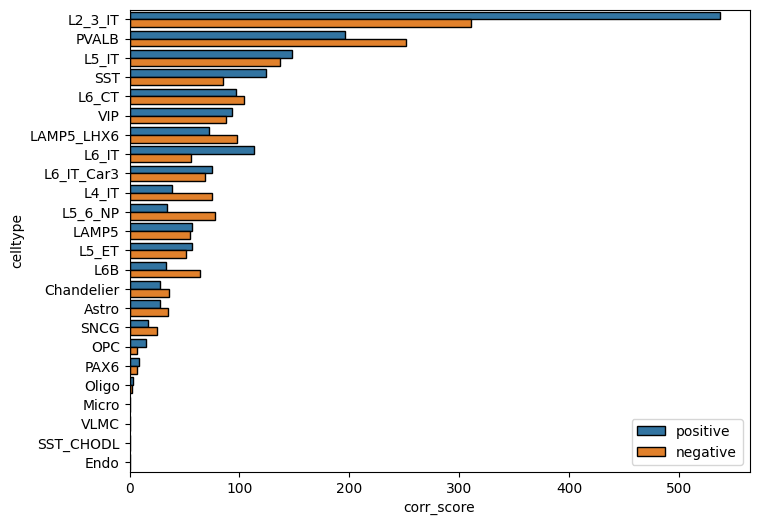

In [33]:
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized/")
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8),
fig.set_figheight(6)
sns.barplot(
    plot_table_long, 
    y="celltype", 
    x="corr_score", 
    hue="direction", 
    ax=ax, 
    linewidth=1,
    edgecolor="black"
)
plt.legend(loc="lower right")
fig.savefig(plot_dir / "ST_all_corr_7e-1_1e-2.pdf", dpi=300, format="pdf")

## Upset plot for ST axis

In [34]:
import os
from pathlib import Path
import matplotlib.pyplot as plt
root_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/data/SNAREdata/scenicplus/")
os.chdir(root_dir / "other_celltypes")
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/scenicplus/L4_IT/figures/finalized//")

In [35]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import scanpy as sc
import decoupler as dc
import numpy as np
import scipy.stats as stats
import seaborn as sns

In [36]:
import itertools

In [37]:
def generate_all_combinations_and_counts(lists):
    combination_codes = []
    number_instances = []

    N = len(lists)
    for k in range(2, N+1):
        for combinations in itertools.combinations(range(N), k):
            combination_codes.append(combinations)
            intersected = set(lists[combinations[0]])
            for idx in combinations[1:]:
                intersected &= set(lists[idx])
            number_instances.append(len(intersected))

    return (combination_codes, number_instances)

In [20]:
celltype_order = []
lists = []
for file in Path("./corr_genes_ST_7e-1_1e-2_expr_filtered/").glob("*_positive.tsv"):
    celltype = file.name.split("_positive.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [21]:
N = 20
K = len(celltype_sorted)

In [22]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [41]:
import matplotlib.gridspec as gridspec

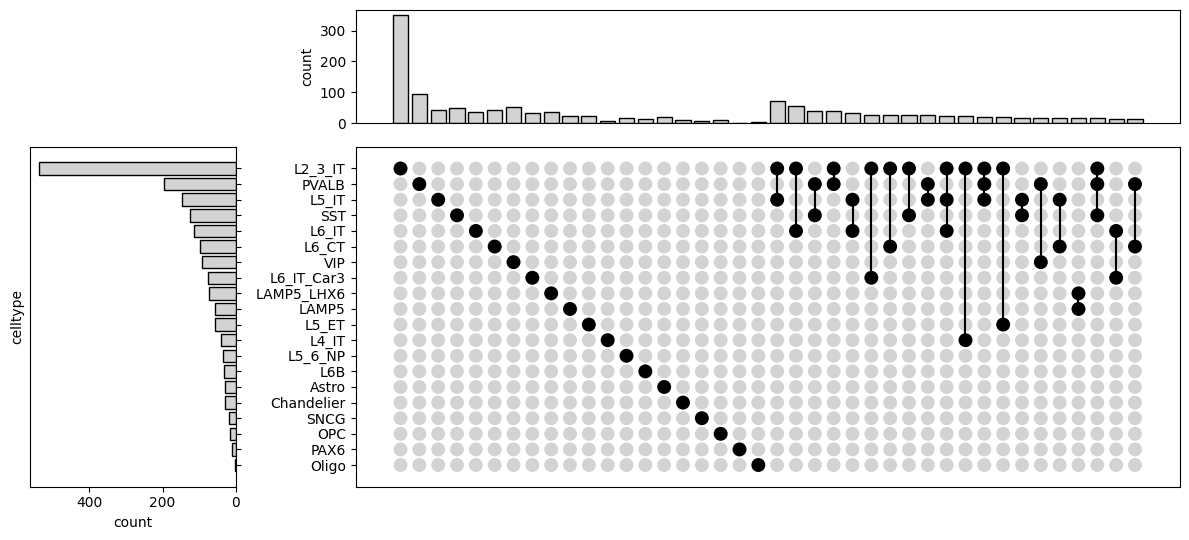

In [42]:
Nx = len(cc_final)
fig = plt.figure(figsize=(12, 5.5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 4])

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax2)

df_1 = pd.DataFrame({
    "celltype": celltype_sorted,
    "count": lists_len_sorted
})
sns.barplot(
    df_1,
    x="count",
    y="celltype",
    orient="h",
    ax=ax1,
    edgecolor="black",
    facecolor="lightgrey"
)
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False);

df_2 = pd.DataFrame({
    "count": number_instances_final
})
df_2.reset_index(inplace=True)
sns.barplot(
    df_2,
    x="index",
    y="count",
    ax=ax2,
    edgecolor="black",
    facecolor="lightgrey"
)
ax2.xaxis.set_ticks([]);
ax2.set_xticklabels([]);
ax2.set_xlabel("");

for i in range(Nx):
    ax3.scatter([i] * (K), np.arange(K), color="lightgrey", s=100, edgecolor="none")
points_by_x = {x: [] for x in range(Nx)}
for i, tuple_vals in enumerate(cc_final):
    ax3.scatter([i] * len(tuple_vals), tuple_vals, color="black", s=100, edgecolor="none")
    for x in tuple_vals:
        points_by_x[i].append(x)
for x, yvals in points_by_x.items():
    ax3.plot([x] * len(yvals), yvals, color="black", lw=1.5)
    
ax3.xaxis.set_ticks([]);
ax3.set_xticklabels([]);
ax3.set_xlabel("");
# ax3.yaxis.set_ticks(np.arange(0, K));
# ax3.invert_yaxis()
plt.tight_layout()
fig.savefig(plot_dir / "ST_all_positive_corr_7e-1_bh_1e-2_upset.pdf", dpi=300, format="pdf")

In [25]:
celltype_order = []
lists = []
for file in Path("./corr_genes_ST_7e-1_1e-2_expr_filtered/").glob("*_negative.tsv"):
    celltype = file.name.split("_negative.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [26]:
N = 20
K = len(celltype_sorted)

In [27]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

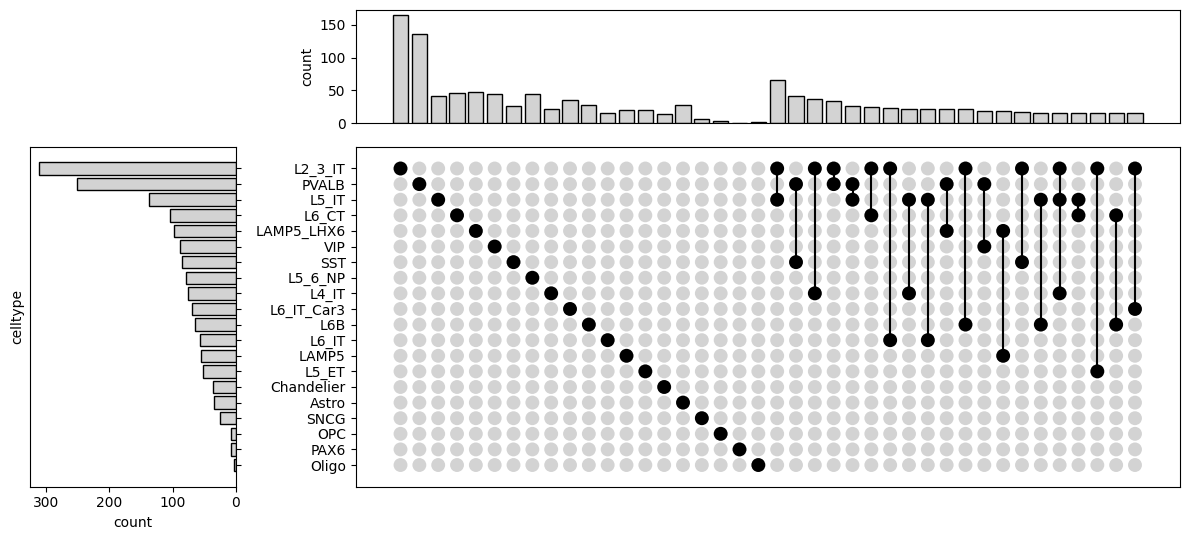

In [46]:
Nx = len(cc_final)
fig = plt.figure(figsize=(12, 5.5))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 3], width_ratios=[1, 4])

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1, sharex=ax2)

df_1 = pd.DataFrame({
    "celltype": celltype_sorted,
    "count": lists_len_sorted
})
sns.barplot(
    df_1,
    x="count",
    y="celltype",
    orient="h",
    ax=ax1,
    edgecolor="black",
    facecolor="lightgrey"
)
ax1.invert_xaxis()
ax1.yaxis.tick_right()
ax1.tick_params(labelright=False);

df_2 = pd.DataFrame({
    "count": number_instances_final
})
df_2.reset_index(inplace=True)
sns.barplot(
    df_2,
    x="index",
    y="count",
    ax=ax2,
    edgecolor="black",
    facecolor="lightgrey"
)
ax2.xaxis.set_ticks([]);
ax2.set_xticklabels([]);
ax2.set_xlabel("");

for i in range(Nx):
    ax3.scatter([i] * (K), np.arange(K), color="lightgrey", s=100, edgecolor="none")
points_by_x = {x: [] for x in range(Nx)}
for i, tuple_vals in enumerate(cc_final):
    ax3.scatter([i] * len(tuple_vals), tuple_vals, color="black", s=100, edgecolor="none")
    for x in tuple_vals:
        points_by_x[i].append(x)
for x, yvals in points_by_x.items():
    ax3.plot([x] * len(yvals), yvals, color="black", lw=1.5)
    
ax3.xaxis.set_ticks([]);
ax3.set_xticklabels([]);
ax3.set_xlabel("");
# ax3.yaxis.set_ticks(np.arange(0, K));
# ax3.invert_yaxis()
plt.tight_layout()
fig.savefig(plot_dir / "ST_all_negative_corr_7e-1_bh_1e-2_upset.pdf", dpi=300, format="pdf")

### ST ATAC

In [3]:
celltype_names = []
positive_nbr = []
negative_nbr = []
for file in Path("./").glob("*atac_matrix.mtx"):
    celltype = str(file).split("_atac_matrix", 1)[0]
    print(celltype)
    celltype_names.append(celltype)
    
    # atac_counts = sc.read_mtx("{}_atac_matrix.mtx".format(celltype))
    # atac_counts = atac_counts.T.copy()
    # cell_meta = pd.read_csv("{}_meta_data.tsv".format(celltype), header=0, index_col=0, sep="\t")
    # region_names = pd.read_csv("{}_region_names.tsv".format(celltype), header=None, index_col=0, sep="\t")
    # region_names.index.name = None
    # atac_counts.obs = cell_meta
    # atac_counts.var = region_names
    # atac_counts.write("{}_atac_matrix.h5ad".format(celltype))

    atac_counts = sc.read_h5ad("{}_atac_matrix.h5ad".format(celltype))
    atac_counts.obs["Donor_Region"] = \
        atac_counts.obs["PatientID"].astype("str") + "_" + atac_counts.obs["Region"].astype("str")
    atac_region_counts = dc.get_pseudobulk(
        adata=atac_counts,
        sample_col="Donor_Region",
        groups_col=None,
        min_cells=0,
        min_counts=0,
        remove_empty=True,
        mode="sum"
    )
    kept_regions = dc.filter_by_expr(
        atac_region_counts,
        group="Region",
        min_count=5,
        min_total_count=15
    )
    if len(kept_regions) <= 5:
        print("{} <=5 regions left after filtering...".format(celltype))
        continue

    sc.pp.normalize_total(atac_region_counts, target_sum=1e6)
    sc.pp.log1p(atac_region_counts, base=2)
    atac_region_counts = atac_region_counts[:, kept_regions].copy()
    region_align = ["A24", "A9", "FI", "MTG", "AnG", "M1C", "S1C", "A1C", "V1C"]
    atac_region_counts.obs["Region"] = pd.Categorical(
        atac_region_counts.obs["Region"], categories=region_align
    )
    sorted_index = atac_region_counts.obs.sort_values(by="Region").index
    b = atac_region_counts.obs.loc[sorted_index, "Region"].cat.codes.to_list()
    data_matrix = atac_region_counts[sorted_index, :].X
    corrs = np.zeros(data_matrix.shape[1])
    pvalues = np.zeros(data_matrix.shape[1])
    
    for i in range(0, data_matrix.shape[1]):
        a = data_matrix[:, i]
        corr, pvalue = stats.spearmanr(a, b)
        corrs[i] = corr
        pvalues[i] = pvalue
    padjusted = stats.false_discovery_control(pvalues, method="bh")
    spearman_result = pd.DataFrame({
        "region": atac_region_counts.var.index.to_list(),
        "corr": corrs,
        "p_value": pvalues,
        "p_adjusted": padjusted,
    })

    spearman_result.to_csv(
        "corr_regions_ST_5e-1_5e-2_expr_filtered/{}_ST_table.tsv".format(celltype), sep="\t", header=True, index=False)

    pos_regions = spearman_result[
        (spearman_result["p_adjusted"] < 0.05) &
        (spearman_result["corr"] > 0.5)
    ]["region"].to_list()
    positive_nbr.append(len(pos_regions))
    with open("corr_regions_ST_5e-1_5e-2_expr_filtered/{}_positive.tsv".format(celltype), "w") as fout:
        for region in pos_regions:
            fout.write("{}\n".format(region))

    neg_regions = spearman_result[
        (spearman_result["p_adjusted"] < 0.05) &
        (spearman_result["corr"] < -0.5)
    ]["region"].to_list()
    negative_nbr.append(len(neg_regions))
    with open("corr_regions_ST_5e-1_5e-2_expr_filtered/{}_negative.tsv".format(celltype), "w") as fout:
        for region in neg_regions:
            fout.write("{}\n".format(region))
            
    with open("corr_regions_ST_5e-1_5e-2_expr_filtered/{}_full_list.tsv".format(celltype), "w") as fout:
        for region in spearman_result["region"].to_list():
            fout.write("{}\n".format(region))

L4_IT
L2_3_IT
VLMC
Oligo
L5_6_NP
SST
VIP
OPC
Astro
L6_IT
SST_CHODL
SST_CHODL <=5 regions left after filtering...
LAMP5_LHX6
L5_IT
PVALB
Endo
Chandelier
L6_CT
L5_ET
SNCG
PAX6
Micro
L6_IT_Car3
LAMP5
L6B


In [4]:
plot_table_wide = pd.DataFrame({
    "celltype": [xx for xx in celltype_names if xx != "SST_CHODL"],
    "positive": positive_nbr,
    "negative": negative_nbr
})

In [5]:
plot_table_wide.to_csv(
    "summary_tables/ST_corr_peaks_all_celltypes.tsv",
    header=True, index=False, sep="\t"
)

In [6]:
plot_table_wide = pd.read_csv(
    "summary_tables/ST_corr_peaks_all_celltypes.tsv",
    header=0, sep="\t"
)

In [7]:
plot_table_wide["total"] = plot_table_wide["positive"] + plot_table_wide["negative"]
sorted_index = plot_table_wide.sort_values("total", ascending=False)["celltype"]
plot_table_wide["celltype"] = pd.Categorical(plot_table_wide["celltype"], categories=sorted_index)
plot_table_long = pd.melt(
    plot_table_wide, 
    id_vars=["celltype"], 
    value_vars=["positive", "negative"],
    var_name="direction",
    value_name="corr_score"
)

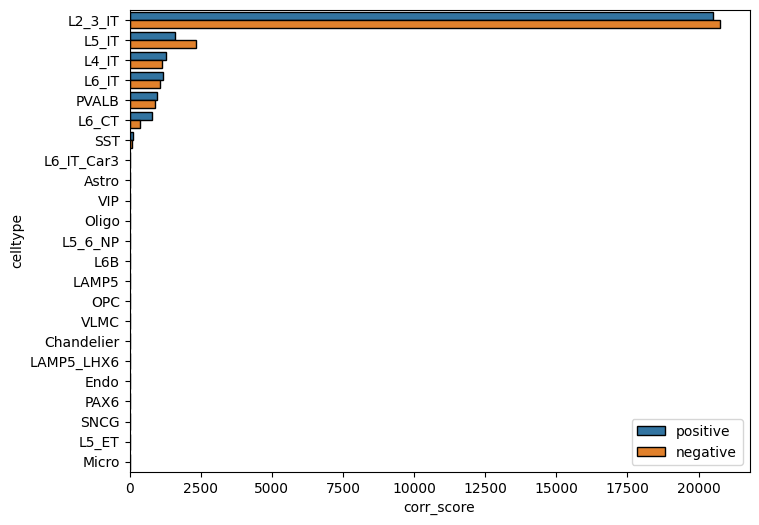

In [8]:
plot_dir = Path("/tscc/projects/ps-epigen/users/biy022/biccn/analysis/final_figures/")
fig, ax = plt.subplots(1, 1)
fig.set_figwidth(8),
fig.set_figheight(6)
sns.barplot(
    plot_table_long, 
    y="celltype", 
    x="corr_score", 
    hue="direction", 
    ax=ax, 
    linewidth=1,
    edgecolor="black"
)
plt.legend(loc="lower right")
fig.savefig(plot_dir / "ST_all_atac_corr_5e-1_bh_5e-2.pdf", dpi=300, format="pdf")

## ATAC

In [27]:
celltype_order = []
lists = []
for file in Path("./corr_regions_ST_5e-1_5e-2_expr_filtered/").glob("*_positive.tsv"):
    celltype = file.name.split("_positive.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [28]:
N = 20
K = len(celltype_sorted)

In [29]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [30]:
print(lists_len_sorted.tolist())

[20517, 1607, 1267, 1185, 964, 792, 117, 32, 11, 8, 7, 1, 1]


In [31]:
print(celltype_sorted)

['L2_3_IT', 'L5_IT', 'L4_IT', 'L6_IT', 'PVALB', 'L6_CT', 'SST', 'L6_IT_Car3', 'Oligo', 'Astro', 'VIP', 'L5_6_NP', 'L6B']


In [32]:
print(number_instances_final)

[18762, 943, 620, 708, 745, 556, 89, 18, 11, 7, 5, 1, 1, 602, 566, 409, 193, 181, 91, 81, 62, 47, 46, 45, 40, 35, 26, 23, 23, 23, 21, 19, 18]


In [33]:
celltype_order = []
lists = []
for file in Path("./corr_regions_ST_5e-1_5e-2_expr_filtered/").glob("*_negative.tsv"):
    celltype = file.name.split("_negative.tsv")[0]
    if file.stat().st_size <= 0:
        continue
    celltype_order.append(celltype)
    curr_df = pd.read_csv(file, header=None, sep="\t")
    lists.append(curr_df[0].to_list())
lists_len = [len(li) for li in lists]
lists_len_sorted = np.sort(lists_len)[::-1]
lists_len_sorted_index = np.argsort(lists_len)[::-1]
celltype_sorted = [celltype_order[ii] for ii in lists_len_sorted_index]
lists_sorted = [lists[ii] for ii in lists_len_sorted_index]
combination_codes, number_instances = generate_all_combinations_and_counts(lists_sorted)
number_instances_sorted = np.sort(number_instances)[::-1]
number_instances_sorted_index = np.argsort(number_instances)[::-1]
combination_codes_sorted = [combination_codes[ii] for ii in number_instances_sorted_index]

In [34]:
N = 20
K = len(celltype_sorted)

In [35]:
unique_elements = []
sets = [set(li) for li in lists_sorted]
for i, curr_set in enumerate(sets):
    other_sets_union = set.union(*(sets[:i] + sets[(i+1):]))
    unique_to_curr = curr_set - other_sets_union
    unique_elements.append(list(unique_to_curr))
number_unique_elements = [len(ue) for ue in unique_elements]
number_instances_final = number_unique_elements + list(number_instances_sorted[0:N])
cc_header = [(i,) for i in range(0, K)]
cc_final = cc_header + combination_codes_sorted[0:N]

In [36]:
print(lists_len_sorted.tolist())

[20754, 2323, 1145, 1075, 906, 369, 95, 20, 18, 8, 6, 2, 2, 1, 1]


In [37]:
print(celltype_sorted)

['L2_3_IT', 'L5_IT', 'L4_IT', 'L6_IT', 'PVALB', 'L6_CT', 'SST', 'L6_IT_Car3', 'Astro', 'VIP', 'L5_6_NP', 'L6B', 'LAMP5', 'OPC', 'Oligo']


In [38]:
print(number_instances_final)

[18881, 1355, 623, 563, 784, 238, 65, 13, 17, 6, 3, 2, 1, 1, 1, 901, 479, 471, 109, 104, 95, 71, 70, 54, 32, 28, 24, 19, 19, 18, 17, 14, 13, 13, 12]
